In [1]:
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

from scarches.dataset.trvae.data_handling import remove_sparsity
from lataq.models import EMBEDCVAE
from lataq.exp_dict import EXPERIMENT_INFO

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=500)
plt.rcParams['figure.figsize'] = (5, 5)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)
sc.settings.verbosity = 2
%load_ext autoreload
%autoreload 2

Global seed set to 0


In [2]:
PARAMS = {
    'EPOCHS': 50,                                      #TOTAL TRAINING EPOCHS
    'N_PRE_EPOCHS': 40,                                #EPOCHS OF PRETRAINING WITHOUT LANDMARK LOSS
    #'DATA_DIR': '../../lataq_reproduce/data',          #DIRECTORY WHERE THE DATA IS STORED
    #'DATA': 'pancreas',                                #DATA USED FOR THE EXPERIMENT
    'EARLY_STOPPING_KWARGS': {                         #KWARGS FOR EARLY STOPPING
        "early_stopping_metric": "val_landmark_loss",  ####value used for early stopping
        "mode": "min",                                 ####choose if look for min or max
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    'LABELED_LOSS_METRIC': 'dist',           
    'UNLABELED_LOSS_METRIC': 'dist',
    'LATENT_DIM': 25,
    'ALPHA_EPOCH_ANNEAL': 1e3,
    'CLUSTERING_RES': 2,
    'HIDDEN_LAYERS': 3,
    'ETA': 5,
}

In [3]:
adata_raw = sc.read(
    '../data/lambrechts_sub.h5ad'
)

In [4]:
adata = sc.read(
    '../data/hlca_counts_commonvars.h5ad'
)
#adata = adata[:, adata.var.highly_variable].copy()
#adata.X

In [5]:
adata_raw.obs['ann_finest_level'] = [
        adata_raw.obs.loc[cell, f"ann_level_{highest_lev}"]
        for cell, highest_lev in zip(
            adata_raw.obs.index, adata_raw.obs.ann_highest_res
        )
]

In [6]:
adata_raw = adata_raw[:, adata.var_names]

In [7]:
condition_key = 'sample'
cell_type_key = ['ann_finest_level']

In [8]:
lataq_query = EMBEDCVAE.load_query_data(
    adata=adata_raw,
    reference_model='hlca_core_amir/hlca_core_sample/',
    labeled_indices=[],
)

AnnData object with n_obs × n_vars = 93575 × 1897
    obs: 'n_genes_detected', 'total_counts', 'cell_from_tumor', 'subject_ID', 'tumor_site', 'original_celltype_ann', 'sample', 'study', 'study_long', 'dataset', 'last_author_PI', 'lung_vs_nasal', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'scanvi_label', 'ann_finest_level'
    var: 'original_gene_names', 'gene_symbols', 'ensembl'
Embedding dictionary:
 	Num conditions: 202
 	Embedding dim: 20
Encoder Architecture:
	Input Layer in, out and cond: 1897 128 20
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 50
Decoder Architecture:
	First Layer in, out and cond:  50 128 20
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 1897 

166


In [9]:
lataq_query.train(
    n_epochs=50,
    pretraining_epochs=40,
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=PARAMS['ALPHA_EPOCH_ANNEAL'],
    eta=0,
    clustering_res=PARAMS['CLUSTERING_RES'],
    labeled_loss_metric=PARAMS['LABELED_LOSS_METRIC'],
    unlabeled_loss_metric=PARAMS['UNLABELED_LOSS_METRIC'],
    weight_decay=0,
    use_stratified_sampling=False,
    best_reload=False,
)

Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
Therefore integer value of those labels is set to -1
loaders init
loaders init done
0.0005850791931152344
 |████████████████----| 80.0%  - val_loss: 752.5245146880 - val_trvae_loss: 752.5245146880
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
computing neighbors
    using data matrix X directly
    finished (0:01:05)
running Leiden clustering
    finished (0:00:24)
Leiden Clustering succesful. Found 47 clusters.
 |████████████████████| 100.0%  - val_loss: 754.2621567185 - val_trvae_loss: 754.2621567185 - val_landmark_loss: 0.0000000000 - val_unlabeled_loss: 0.9208806552
Saving best state of network...
Best State was in Epoch 40


In [10]:
lataq_query.save('hlca_core_amir_disease', overwrite=True)

In [11]:
lataq_query.model.cuda()

EmbedCVAE(
  (embedding): Embedding(202, 20, max_norm=1)
  (encoder): Encoder(
    (FC): Sequential(
      (L0): CondLayers(
        (expr_L): Linear(in_features=1897, out_features=128, bias=True)
        (cond_L): Linear(in_features=20, out_features=128, bias=False)
      )
      (N0): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
      (A0): ReLU()
      (L1): Linear(in_features=128, out_features=128, bias=True)
      (N1): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
      (A1): ReLU()
      (L2): Linear(in_features=128, out_features=128, bias=True)
      (N2): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
      (A2): ReLU()
    )
    (mean_encoder): Linear(in_features=128, out_features=50, bias=True)
    (log_var_encoder): Linear(in_features=128, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (FirstL): Sequential(
      (L0): CondLayers(
        (expr_L): Linear(in_features=50, out_features=128, bias=False)
        (cond_L): Linear(in_features

In [13]:
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=5, kernel='linear')
emb_pca = pca.fit_transform(embedding)

In [14]:
adata_concat = adata.concatenate(adata_raw)

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [15]:
def embedding_plot(lataq_model, condition_key, emb_pca, adata, components, key):
    cond = (
        adata
        .obs
        .groupby(condition_key)
        .first()
        .reindex(lataq_model.conditions_)
        [key]
    )
    patient_id = lataq_model.conditions_

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    import seaborn as sns
    sns.scatterplot(
        emb_pca[:, components[0]], 
        emb_pca[:, components[1]], 
        cond,
        #hue_order = cond_to_keep,
        #palette = 'Reds',
        ax=ax
    )

    #for i in range(emb_pca.shape[0]):
    #    ax.text(
    #        x=emb_pca[i, components[0]]+0.01,
    #        y=emb_pca[i, components[1]]+0.01,
    #        s=patient_id[i],
    #        fontsize=5
    #    )
    ax.grid(False)
    ax.set_title('Patient embeddings')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sns.despine()
    #ig.savefig('../figures/haniffa_embeddings_query.png', dpi=600, bbox_inches='tight')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


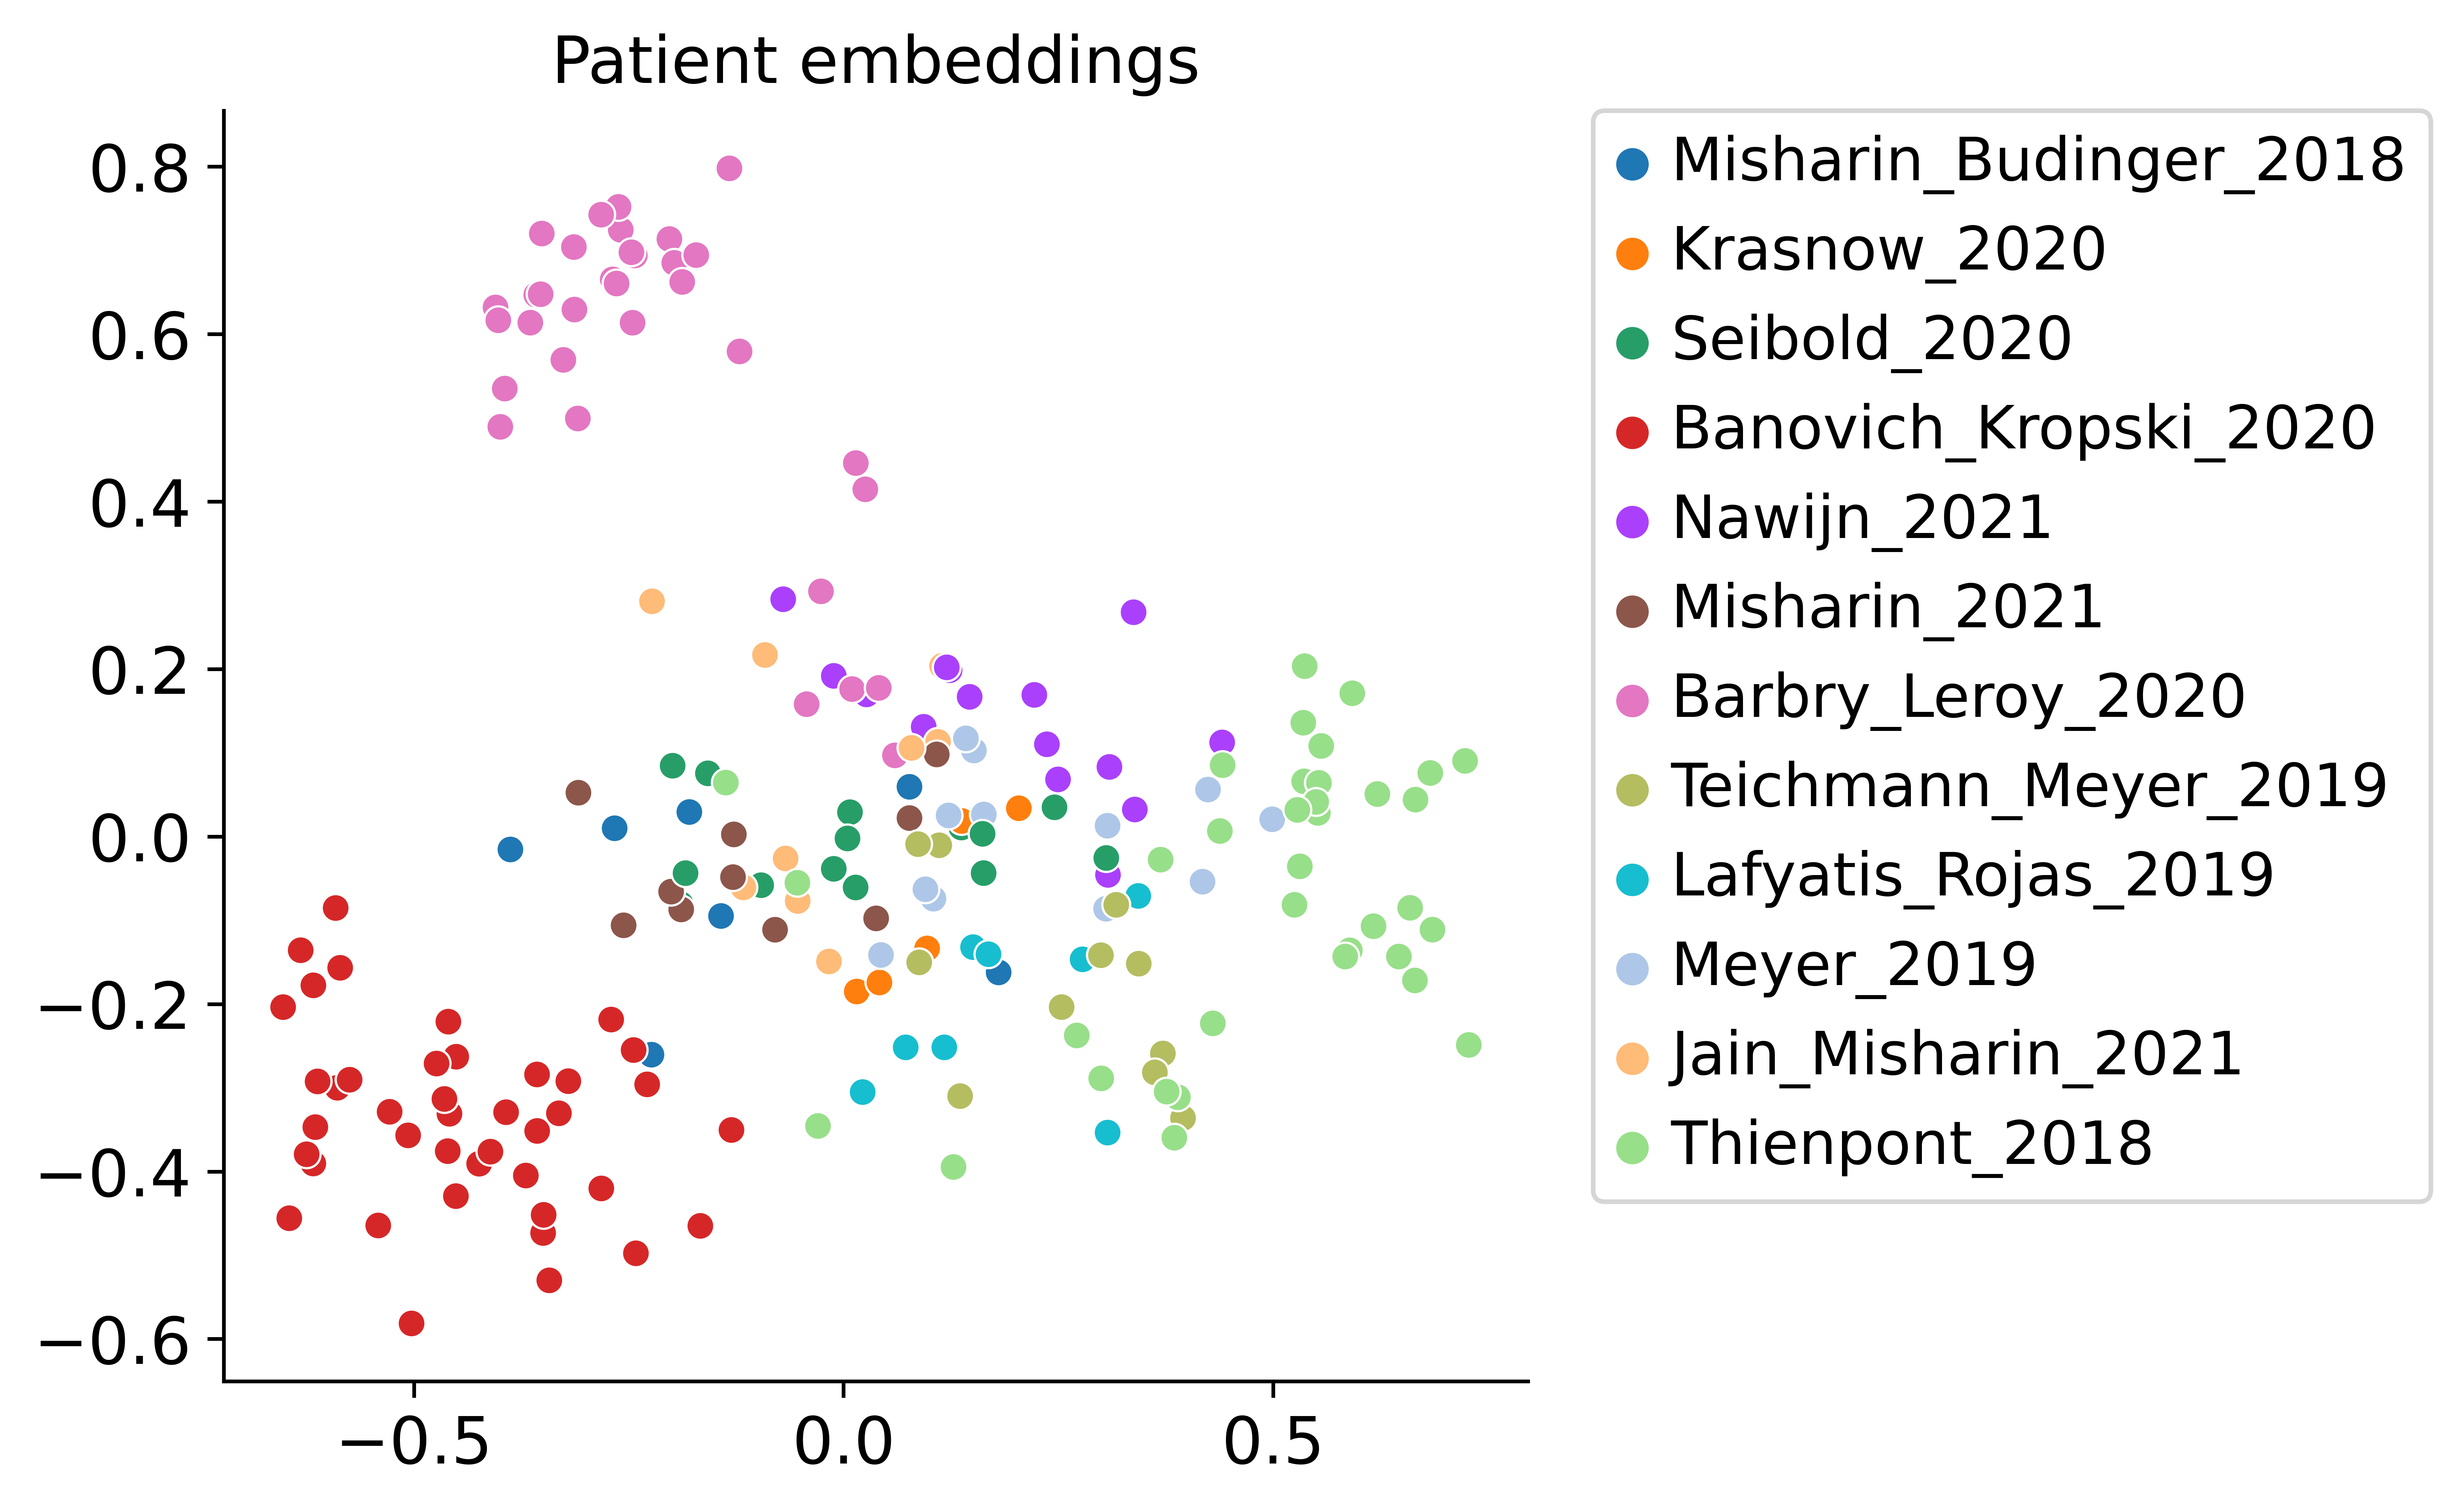

In [16]:
embedding_plot(lataq_query, 'sample', emb_pca, adata_concat, [0, 1], 'study')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


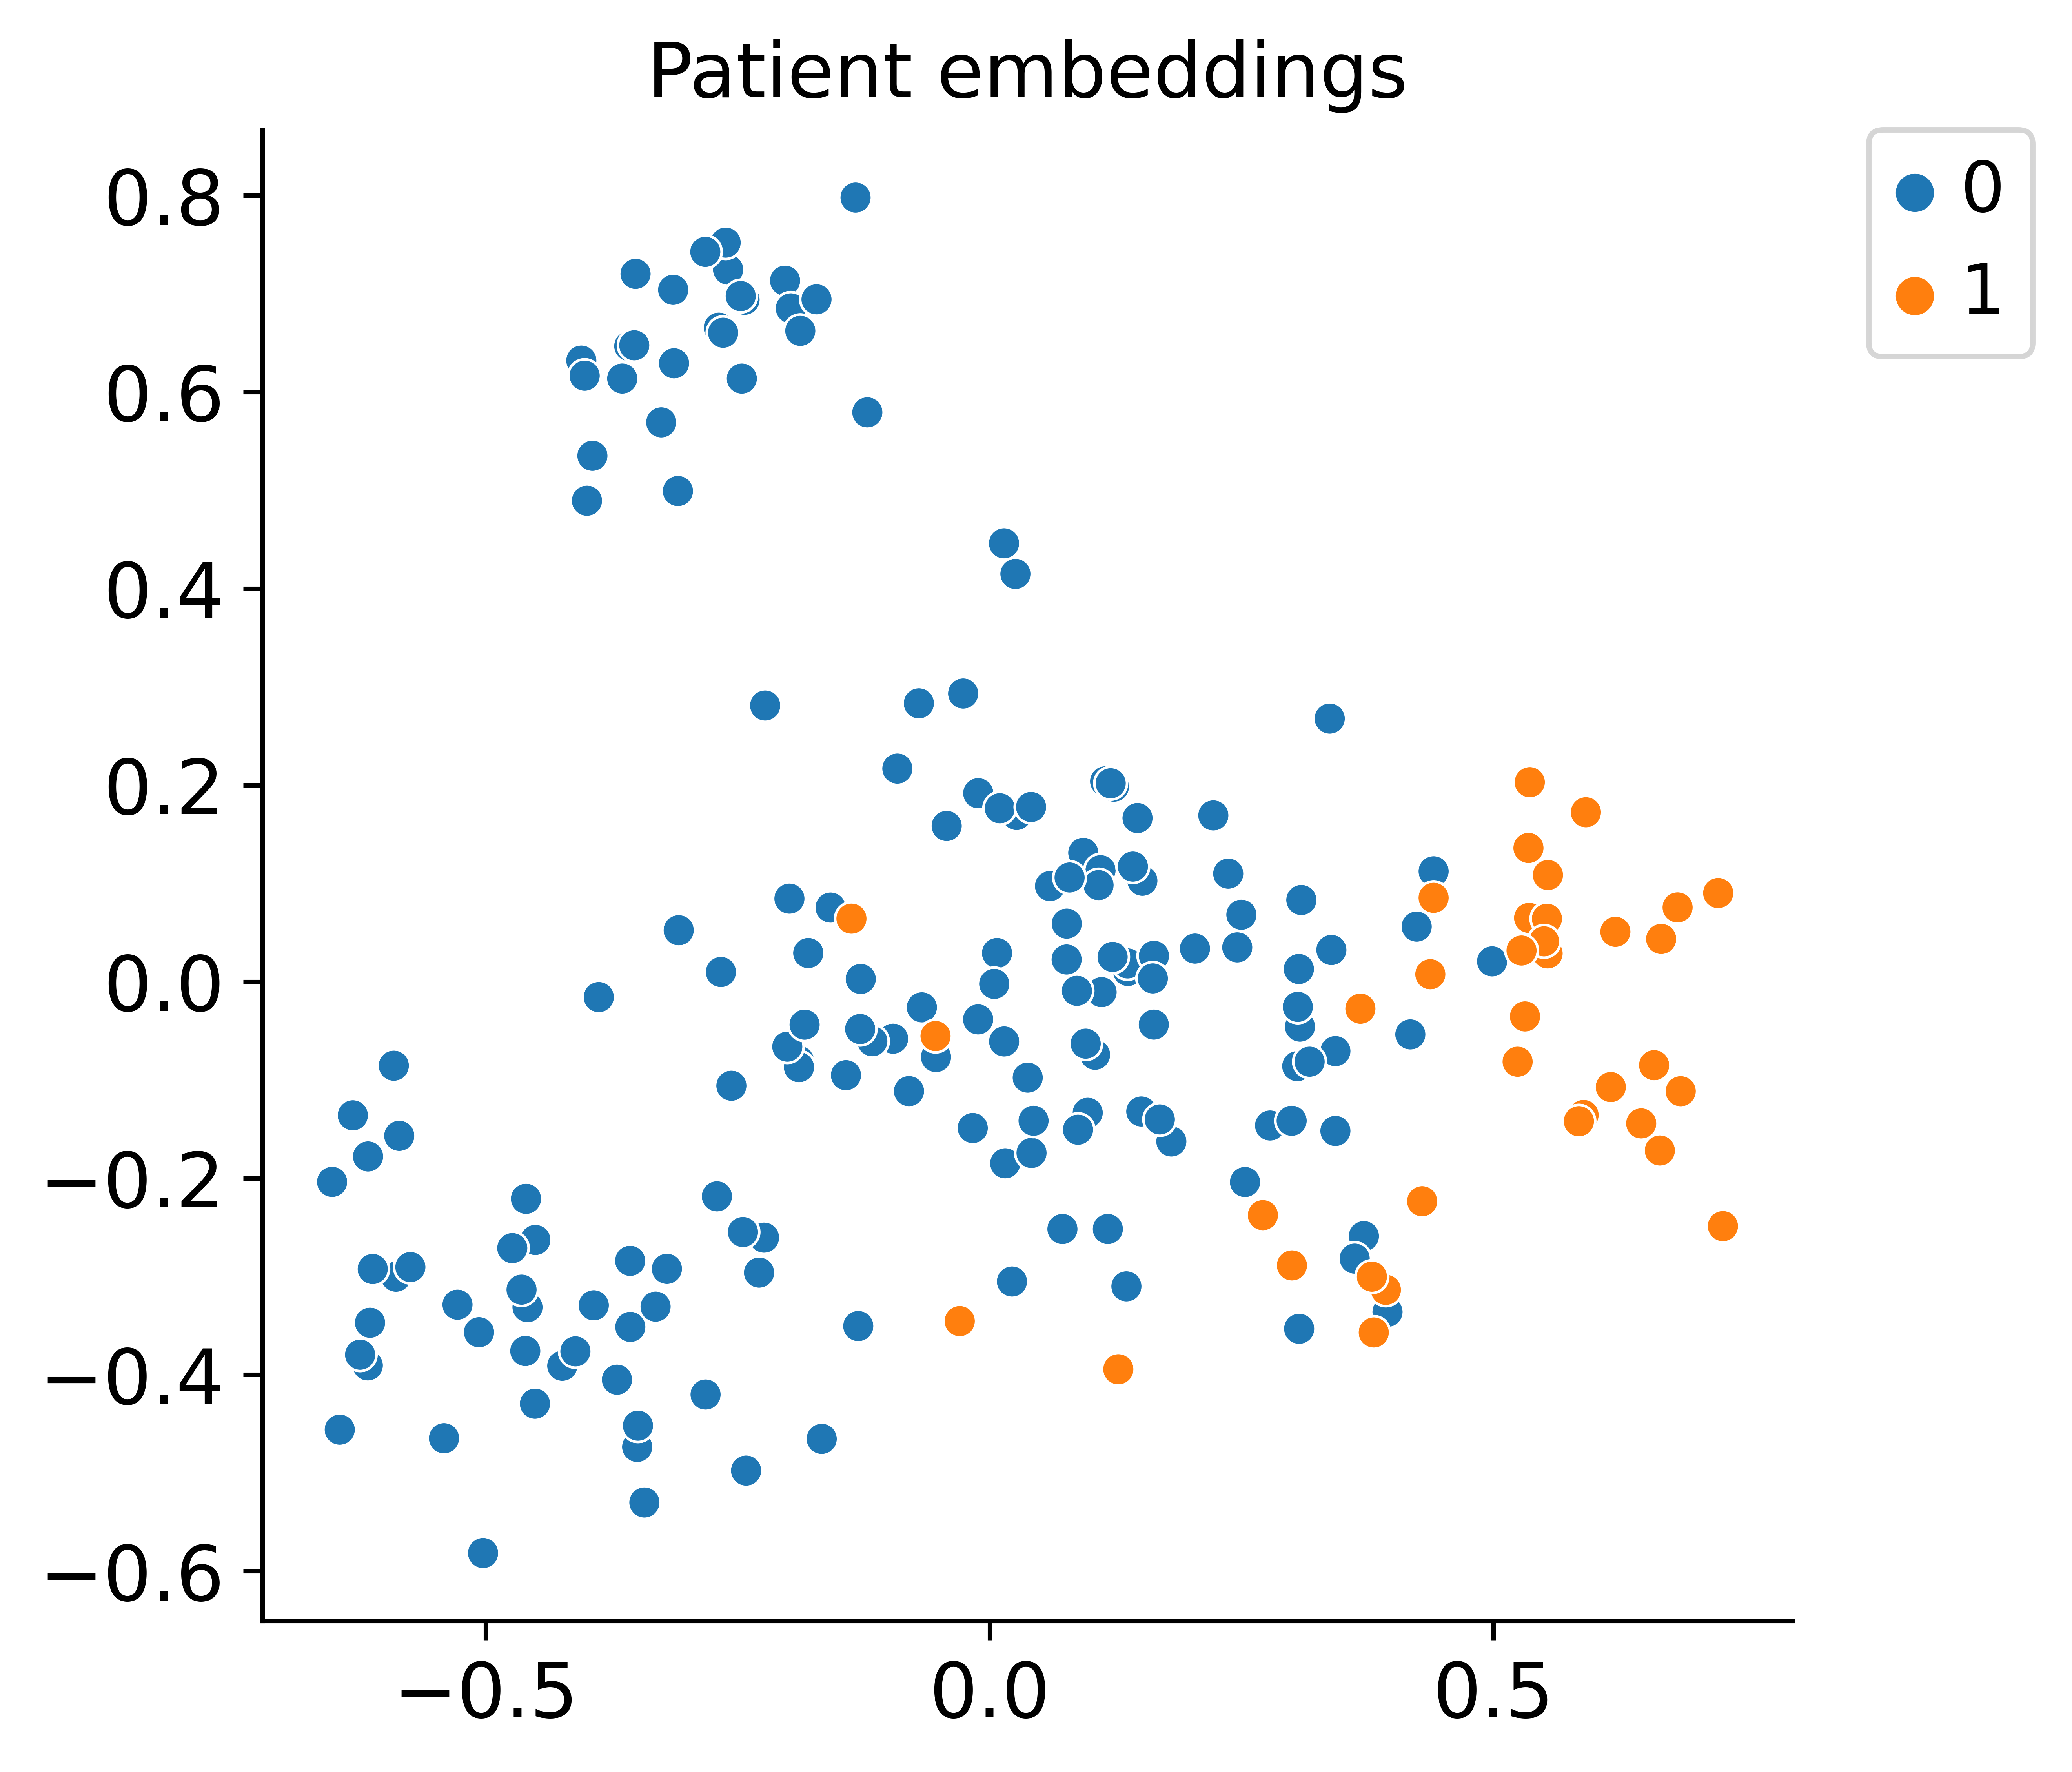

In [18]:
embedding_plot(lataq_query, 'sample', emb_pca, adata_concat, [0, 1], 'batch')